Linear regression to predict streamflow. Forcings are aggregated from hourly to daily to match streamflow resolution.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn import metrics, svm, neural_network, ensemble
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
from src import load_data, evaluate

np.random.seed(0)

In [2]:
data_runoff = load_data.load_discharge_gr4j_vic()

../src/load_data.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(os.path.join(dir, f), skiprows=2, skipfooter=1, index_col=False, header=None, names=['runoff'], na_values='-1.2345')
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [3]:
data_runoff[pd.isna(data_runoff['runoff'])].groupby(['station'])['date'].count()  # Count NAs per station

station
02GC018       44
02GG013       31
04214500    1003
Name: date, dtype: int64

In [4]:
# For each station, read which grid cells belong to its subwatershed
station_cell_mapping = pd.read_csv('../data/station_cell_mapping.csv', skiprows=1, names=['station', 'lat', 'lon', 'row', 'col', 'area'])

In [5]:
rdrs_data = load_data.load_rdrs_forcings()

In [6]:
resampled = rdrs_data.resample('D')
rdrs_daily = resampled.sum().join(resampled.min(), lsuffix='_sum', rsuffix='_min').join(resampled.max().rename(lambda c: c + '_max', axis=1))

In [7]:
month_onehot=pd.get_dummies(data_runoff['date'].dt.month, prefix='month', columns=['month'])
data_runoff = data_runoff.join(month_onehot)

In [8]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
use_runoff_history = False

predictions = {}
actuals = {}
models = {}
for station in data_runoff['station'].unique():
    print(station)
    station_data = data_runoff[data_runoff['station'] == station].set_index('date')
    station_cell_ids = 39 * station_cell_mapping[station_cell_mapping['station'] == station]['col'] \
        + station_cell_mapping[station_cell_mapping['station'] == station]['row']
    
    # For temperature use min/max aggregation. Precipitation: sum. solar fluxes, pressure & humidity don't seem to help (at least with min/max/sum)
    regex = '((RDRS_TT_40m)_({0})_(min|max)|(RDRS_PR0_SFC)_({0})_sum)$'.format('|'.join(map(lambda x: str(x), station_cell_ids)))
    station_rdrs = rdrs_daily.filter(regex=regex, axis=1)
    print(station_rdrs.shape)
    if any(station_data['runoff'].isna()):
        station_data = station_data[~pd.isna(station_data['runoff'])]
        print('Station', station, 'had NA runoff values')
    
    station_data = station_data.join(station_rdrs)
    for i in range(1, history + 1):
        station_data = station_data.join(station_rdrs.shift(i, axis=0), rsuffix='_-{}'.format(i))
        if use_runoff_history:
            station_data['runoff_-{}'.format(i)] = station_data['runoff'].shift(i, axis=0)
    
    station_train = station_data.loc[train_start : '2013-12-31']
    station_test = station_data.loc['2011-01-01' : '2014-12-31']
    
    print('  Fitting model')
    m = linear_model.Ridge(alpha=.5, random_state=123)
    m.fit(station_train.drop(['station', 'runoff'], axis=1), station_train['runoff'])
    
    station_test = station_test[~pd.isna(station_test['runoff'])]
    if len(station_test) == 0:
        print('Skipping', station)
        continue
        
    predict = pd.DataFrame(index=station_test.index)
    predict = predict.join(station_test.drop(['station', 'runoff'], axis=1))
    predict['runoff'] = np.nan
    if use_runoff_history:
        for i in range(history):
            for j in range(i + 1, history + 1):
                predict.iloc[i]['runoff_-{}'.format(j)] = station_test.iloc[i]['runoff_-{}'.format(j)]
    print('  Predicting')
    if not use_runoff_history:
        predict['runoff'] = m.predict(predict.drop('runoff', axis=1))
    else:
        for i in range(len(predict)):
            predict.iloc[i]['runoff'] = m.predict([predict.iloc[i].drop('runoff')])[0]
            for j in range(1, history + 1):
                if (i + j) >= len(predict):
                    break
                predict.iloc[i + j]['runoff_-{}'.format(j)] = predict.iloc[i]['runoff']
    predictions[station] = predict
    actuals[station] = station_test['runoff']
    models[station] = m

04159492
(1827, 42)
  Fitting model
  Predicting
04200500
(1827, 27)
  Fitting model
  Predicting
04161820
(1827, 27)
  Fitting model
  Predicting
04174500
(1827, 51)
  Fitting model
  Predicting
02GC010
(1827, 18)
  Fitting model
  Predicting
02GE007
(1827, 18)
  Fitting model
  Predicting
02GD004
(1827, 18)
  Fitting model
  Predicting
04214500
(1827, 27)
Station 04214500 had NA runoff values
  Fitting model
  Predicting
04213000
(1827, 27)
  Fitting model
  Predicting
02GG009
(1827, 30)
  Fitting model
  Predicting
02GA010
(1827, 36)
  Fitting model
  Predicting
04176500
(1827, 72)
  Fitting model
  Predicting
04177000
(1827, 15)
  Fitting model
  Predicting
02GA047
(1827, 30)
  Fitting model
  Predicting
02GC018
(1827, 21)
Station 02GC018 had NA runoff values
  Fitting model
  Predicting
04166500
(1827, 30)
  Fitting model
  Predicting
04207200
(1827, 15)
  Fitting model
  Predicting
04160600
(1827, 18)
  Fitting model
  Predicting
04215000
(1827, 15)
  Fitting model
  Predicting
0

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


04159492 	NSE: (clipped to 0) 0.47228214911995003
04200500 	NSE: (clipped to 0) 0.4978715630303234
04161820 	NSE: (clipped to 0) 0.5170509719473307
04174500 	NSE: (clipped to 0) 0.5829178397739783
02GC010 	NSE: (clipped to 0) 0.4621528055846882
02GE007 	NSE: (clipped to 0) 0.4082973537576491
02GD004 	NSE: (clipped to 0) 0.4302136282608878
04214500 	NSE: (clipped to 0) 0.31598034510566575
04213000 	NSE: (clipped to 0) 0.481927847596649
02GG009 	NSE: (clipped to 0) 0.4121991001065761
02GA010 	NSE: (clipped to 0) 0.4445255842521679
04176500 	NSE: (clipped to 0) 0.6248784952781192
04177000 	NSE: (clipped to 0) 0.4735576149038211
02GA047 	NSE: (clipped to 0) 0.46441963781886497
02GC018 	NSE: (clipped to 0) 0.43413215757991097
04166500 	NSE: (clipped to 0) 0.5033918897019745
04207200 	NSE: (clipped to 0) 0.4233461401197097
04160600 	NSE: (clipped to 0) 0.4879531617951255
04215000 	NSE: (clipped to 0) 0.34211377935541765
02GA018 	NSE: (clipped to 0) 0.40429117909066425


../src/evaluate.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


02GG006 	NSE: (clipped to 0) 0.35237359795803325
04193500 	NSE: (clipped to 0) 0.6738545722658548
02GC007 	NSE: (clipped to 0) 0.5677443015499114
04208504 	NSE: (clipped to 0) 0.6416059556776419
04199000 	NSE: (clipped to 0) 0.5336301990689905
02GG002 	NSE: (clipped to 0) 0.45944235416091517
04213500 	NSE: (clipped to 0) 0.5153600233238148
02GA038 	NSE: (clipped to 0) 0.3228700739026876
04198000 	NSE: (clipped to 0) 0.6744188827140534
04197100 	NSE: (clipped to 0) 0.4941915590241772
02GB007 	NSE: (clipped to 0) 0.42597984440929026
04165500 	NSE: (clipped to 0) 0.6262921956039955
02GG013 	NSE: (clipped to 0) 0.39943384471712007
02GC002 	NSE: (clipped to 0) 0.40815001055729005
04212100 	NSE: (clipped to 0) 0.6139750836839415
04199500 	NSE: (clipped to 0) 0.44065468805251506
04196800 	NSE: (clipped to 0) 0.4923284417846505
04166100 	NSE: (clipped to 0) 0.4996859558703054
02GG003 	NSE: (clipped to 0) 0.5362683768377895
04164000 	NSE: (clipped to 0) 0.5243513684071521
04159900 	NSE: (clippe

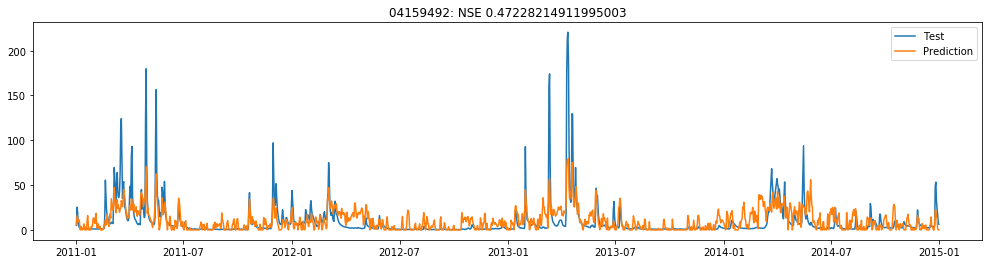

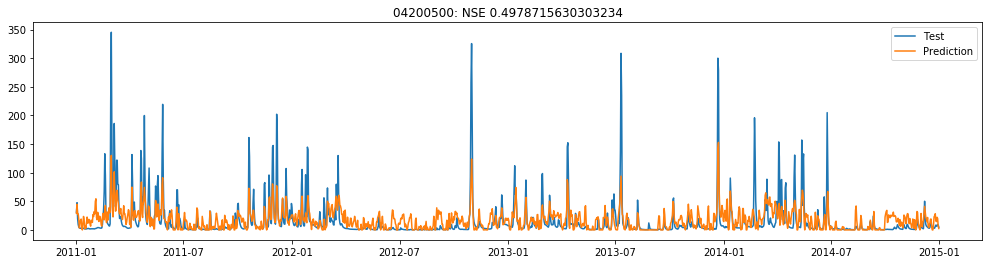

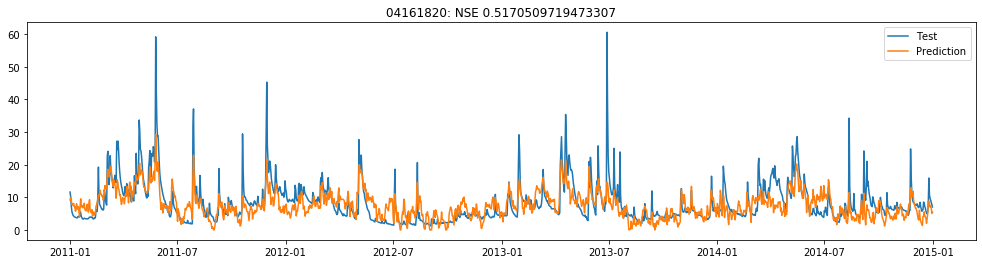

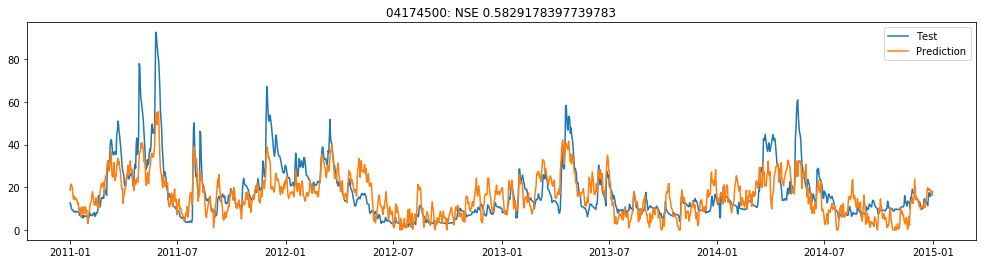

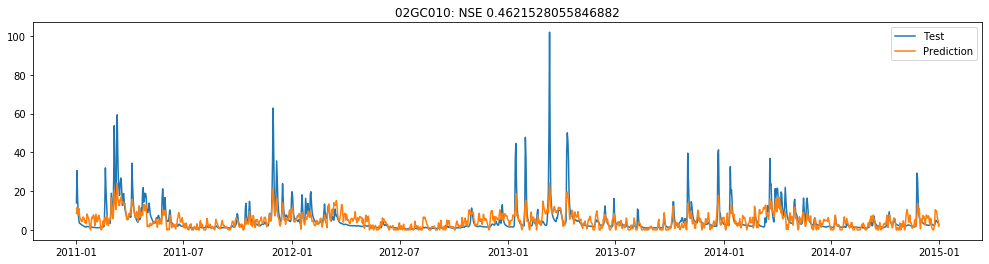

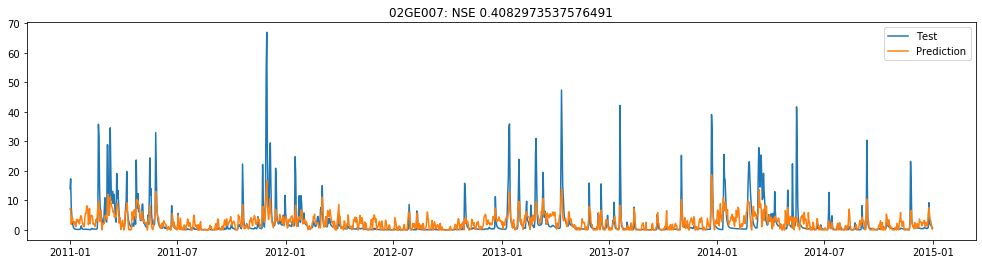

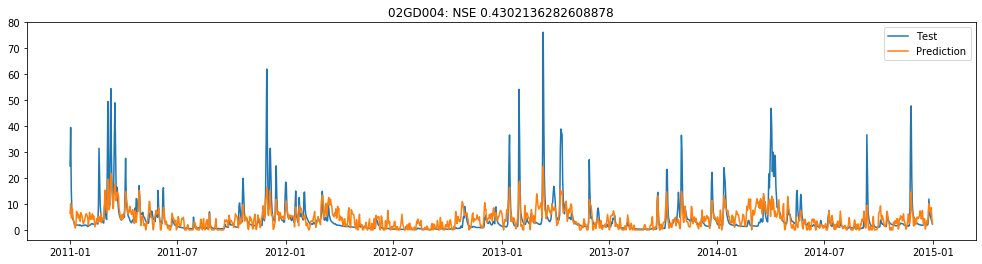

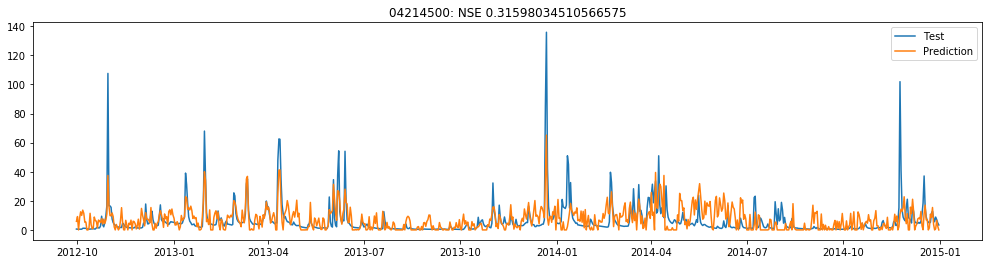

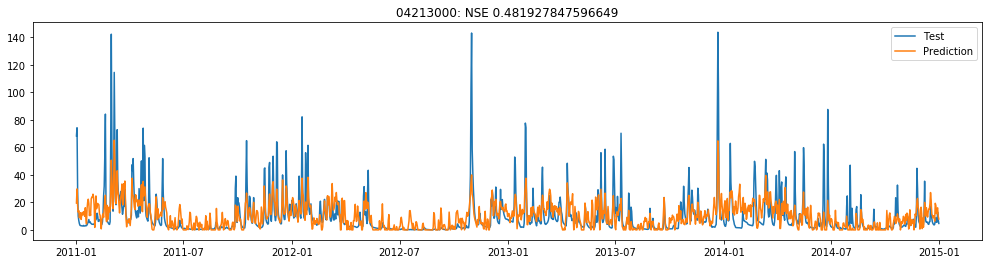

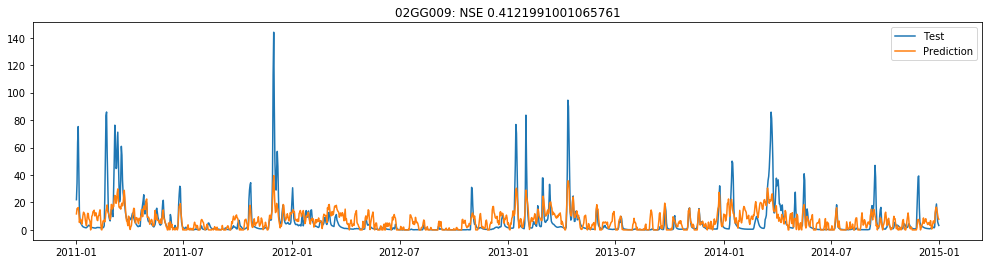

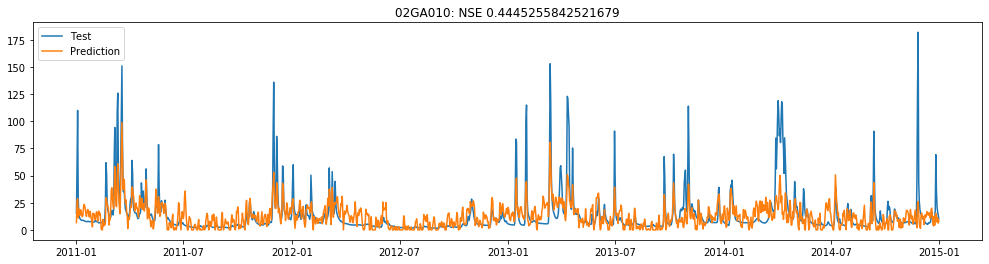

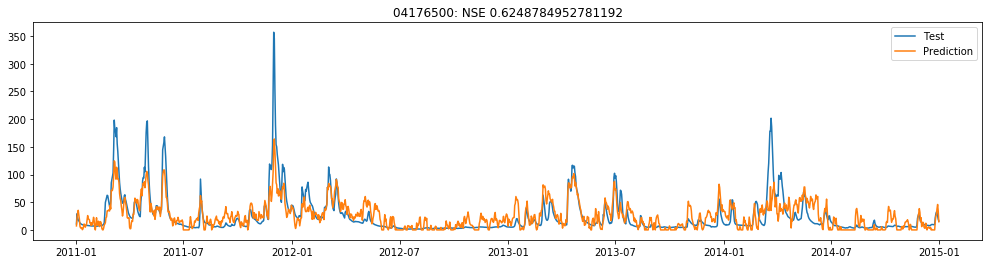

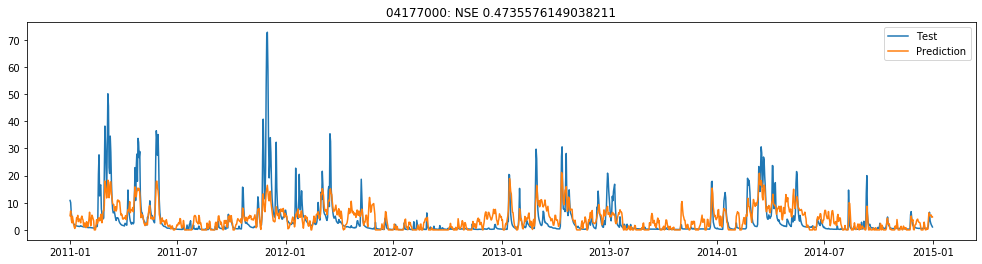

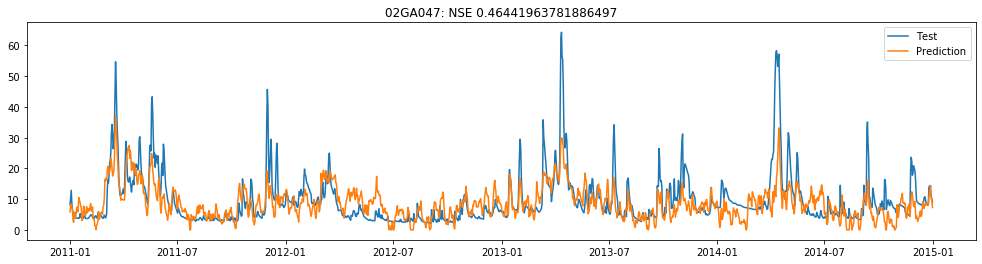

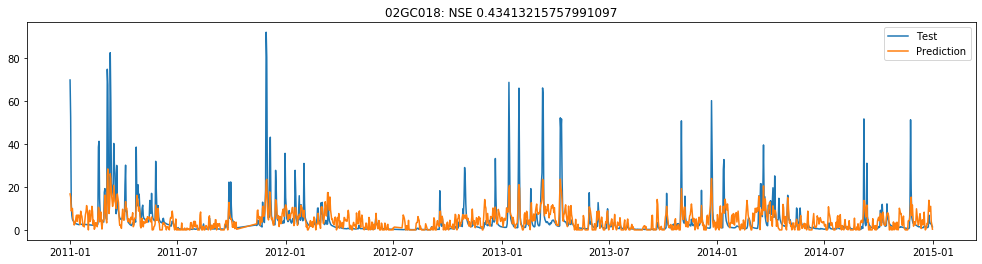

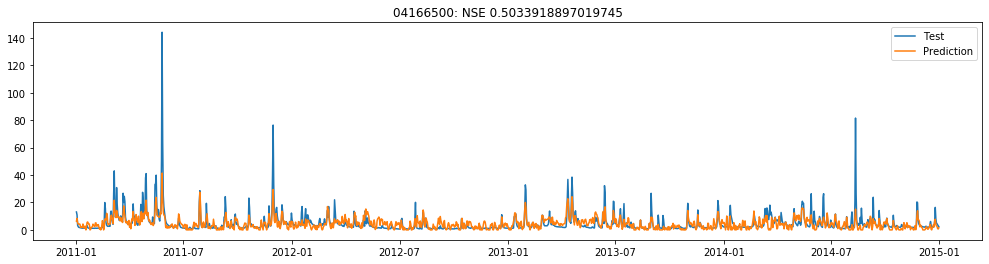

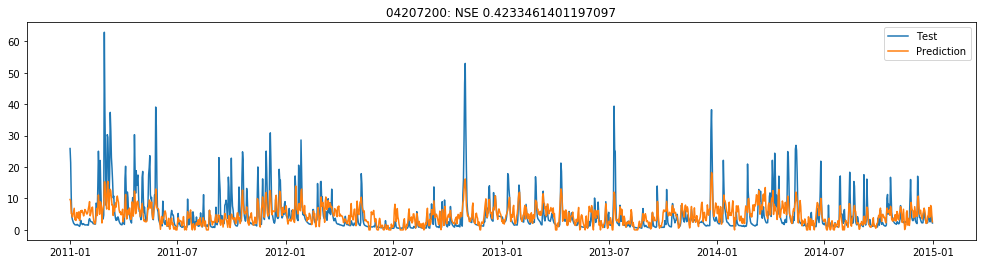

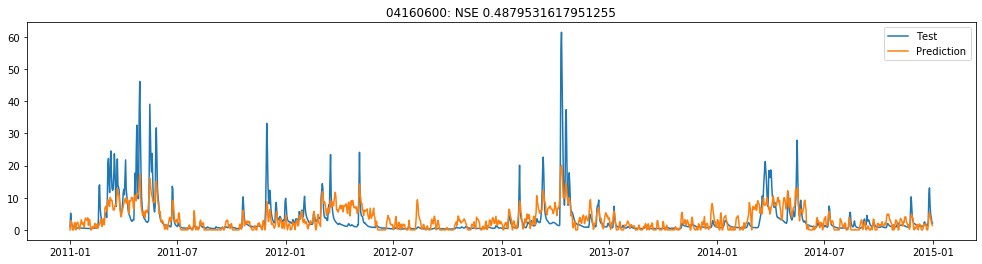

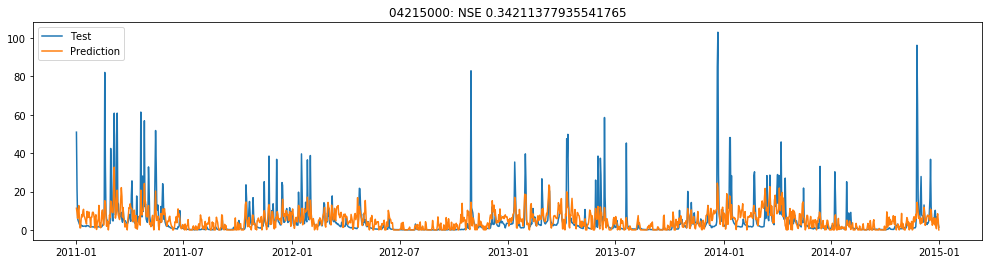

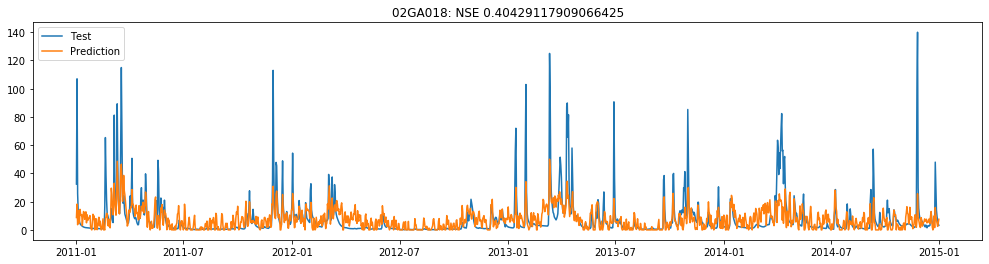

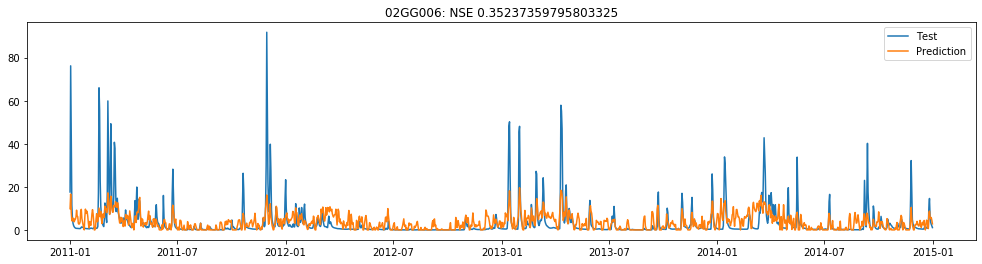

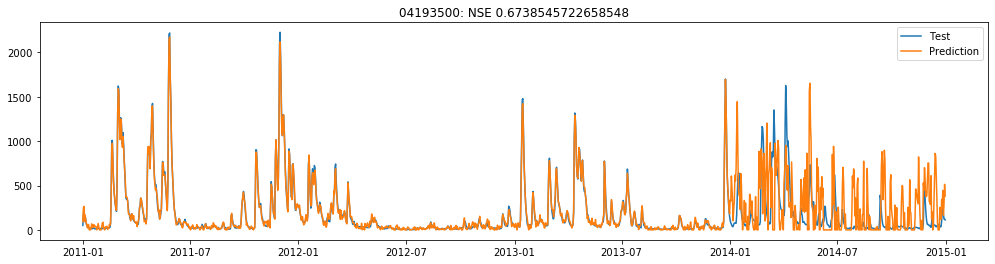

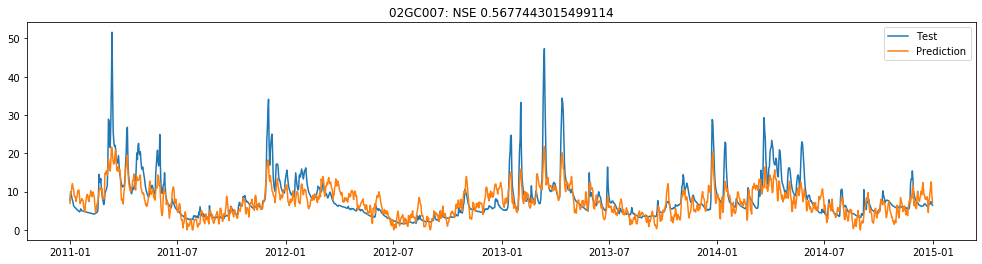

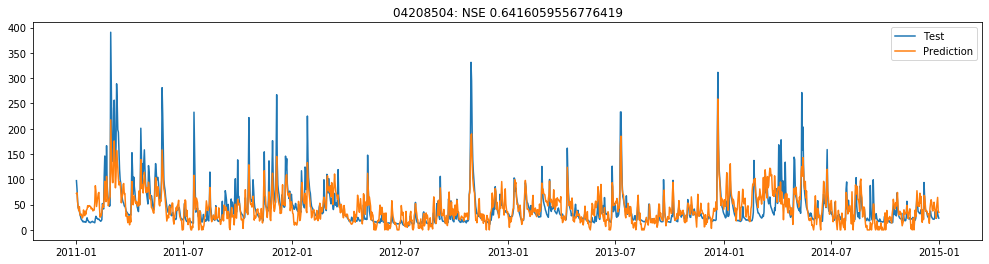

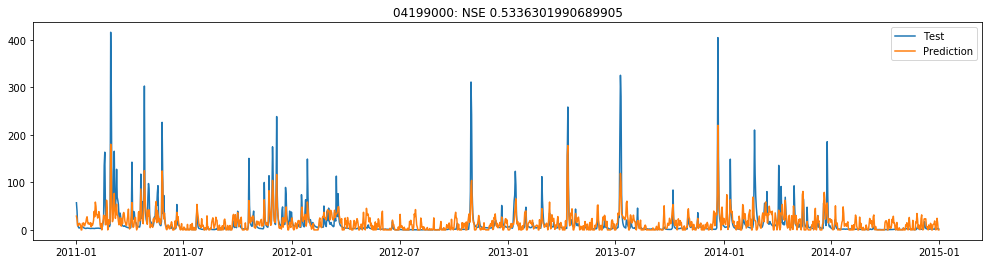

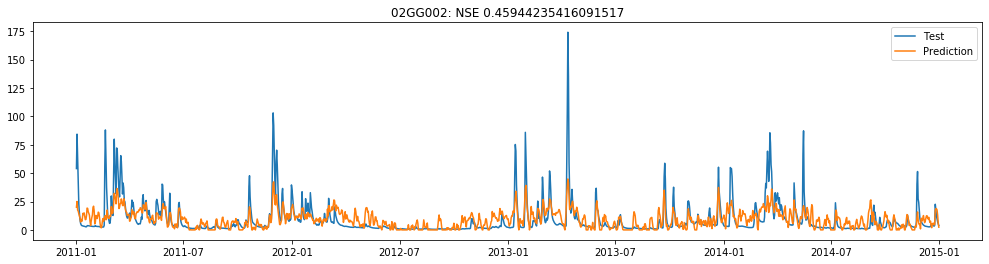

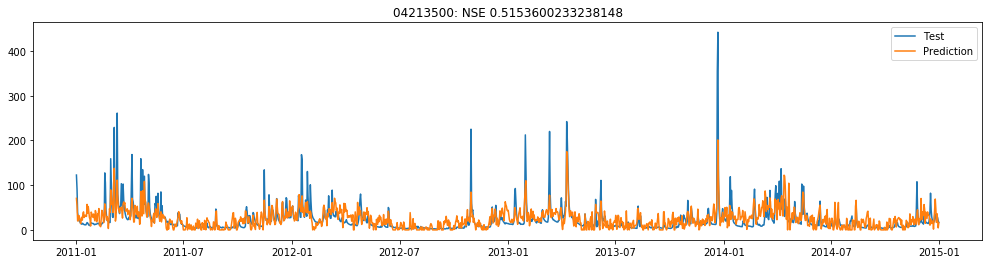

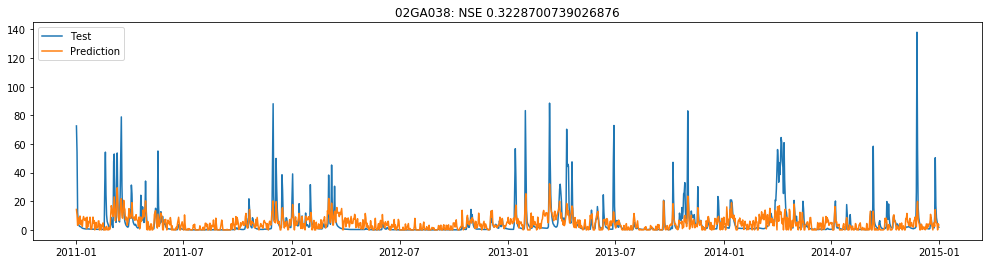

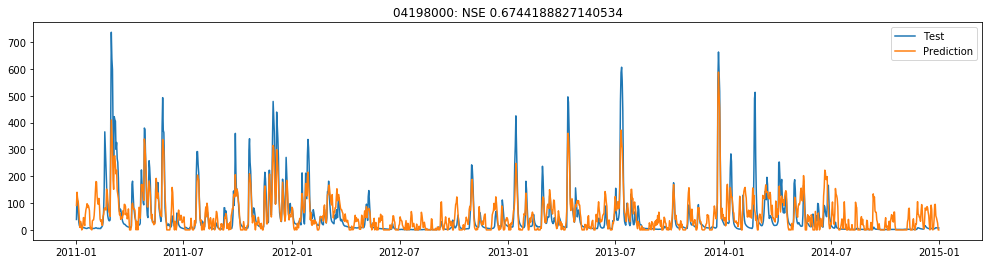

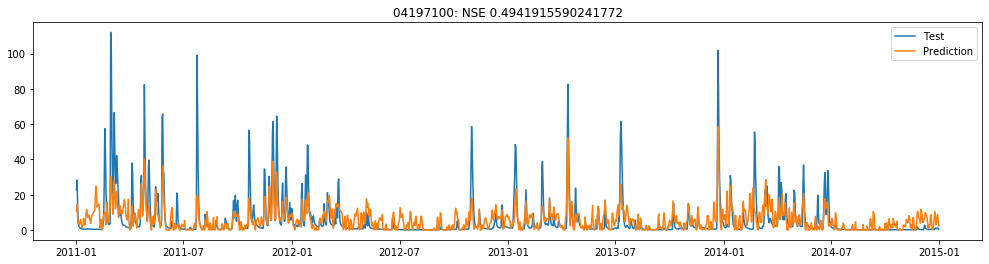

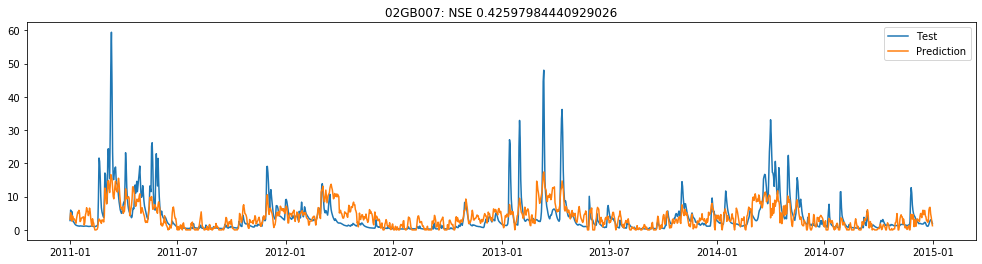

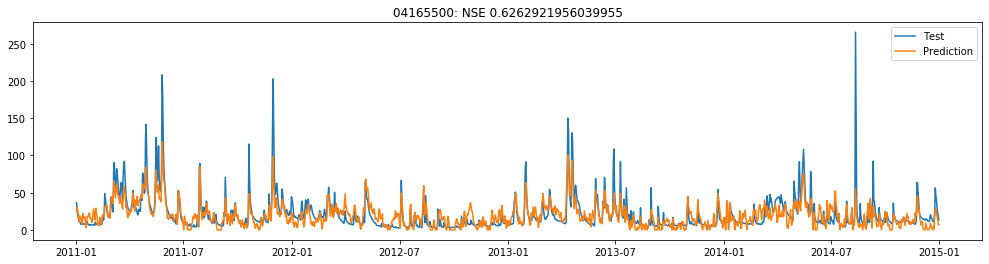

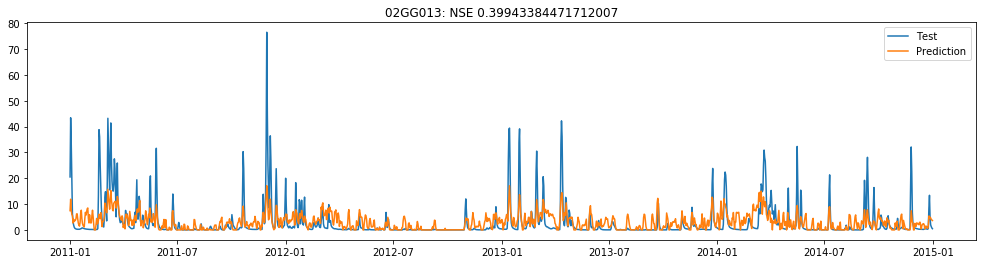

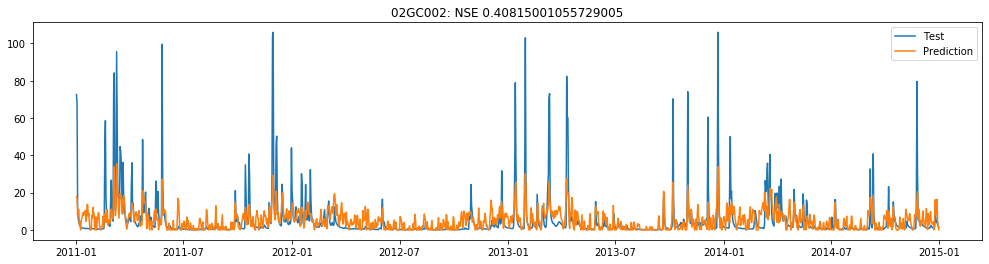

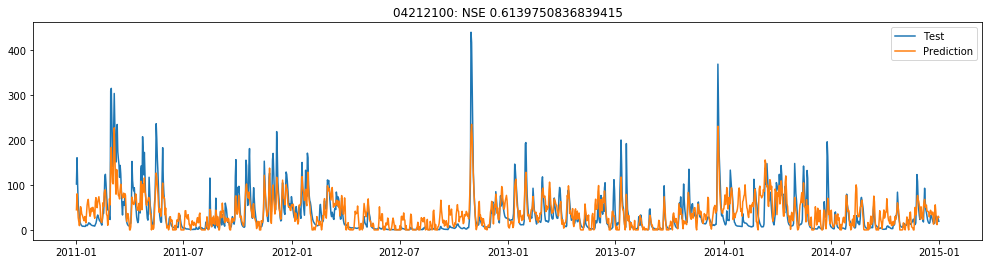

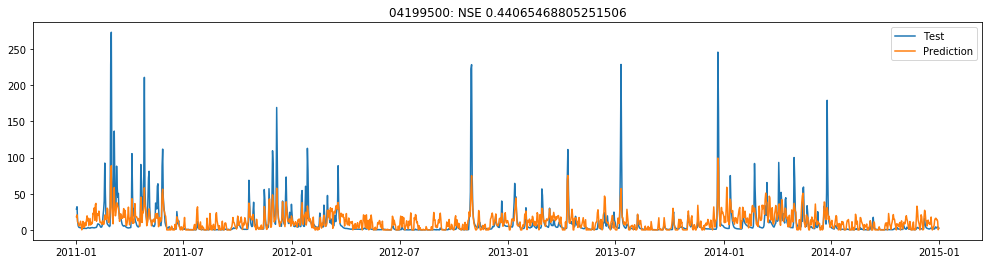

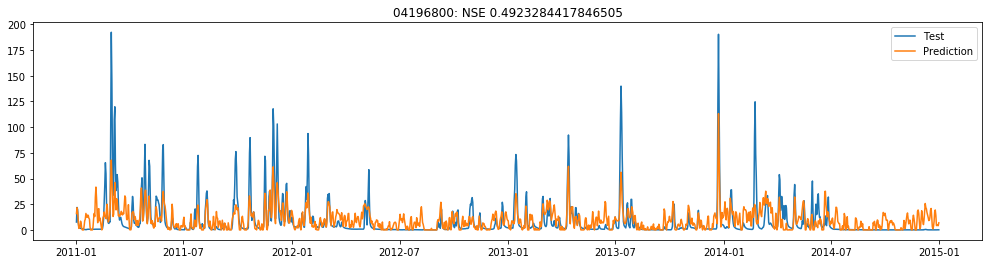

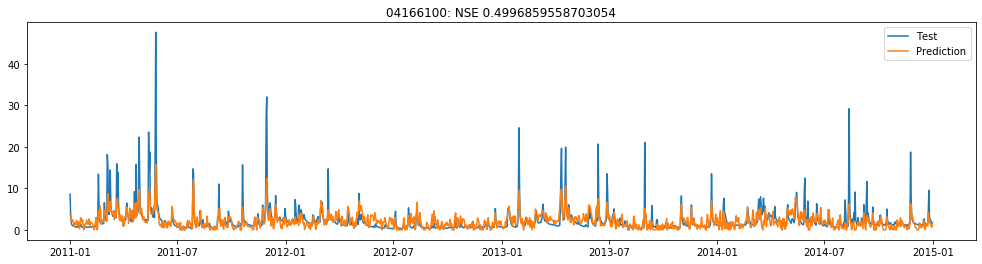

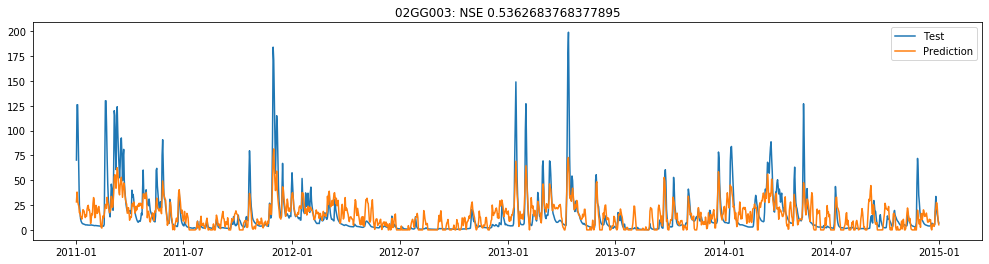

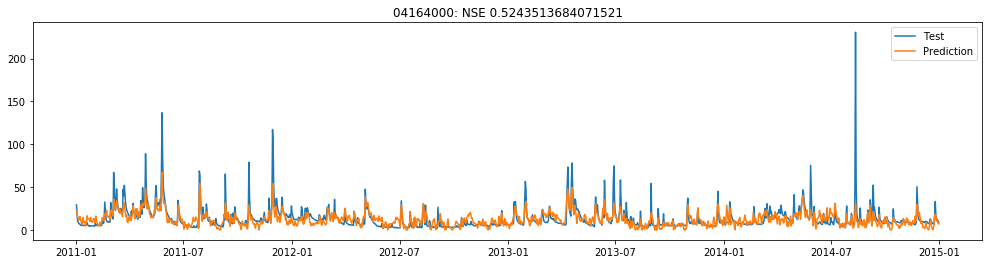

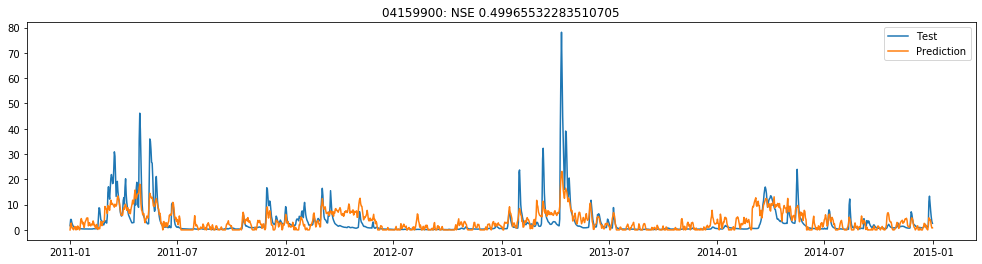

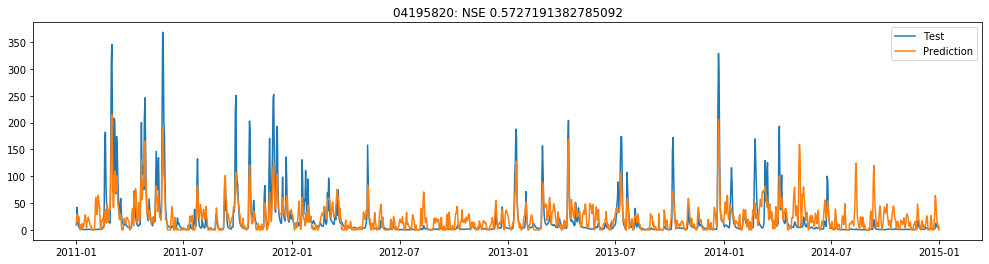

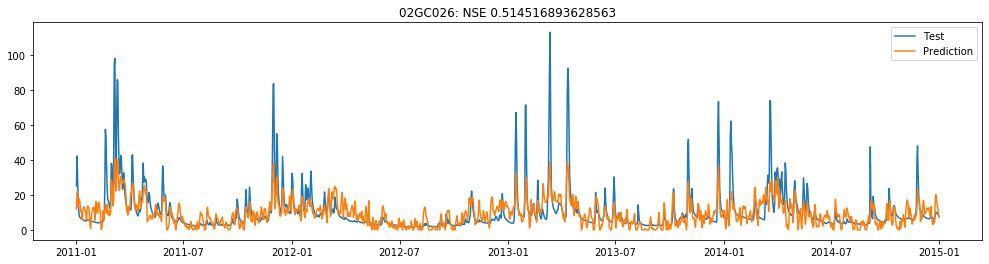

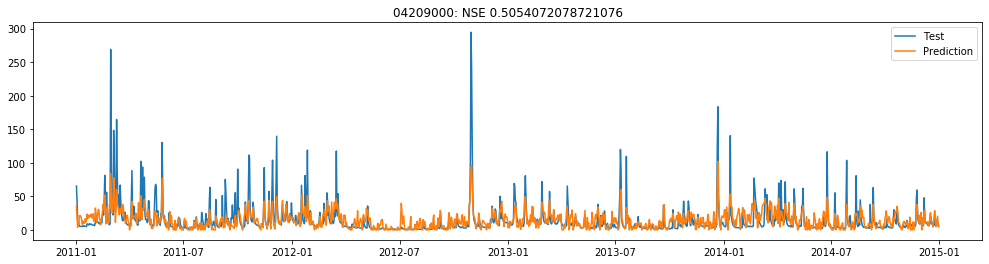

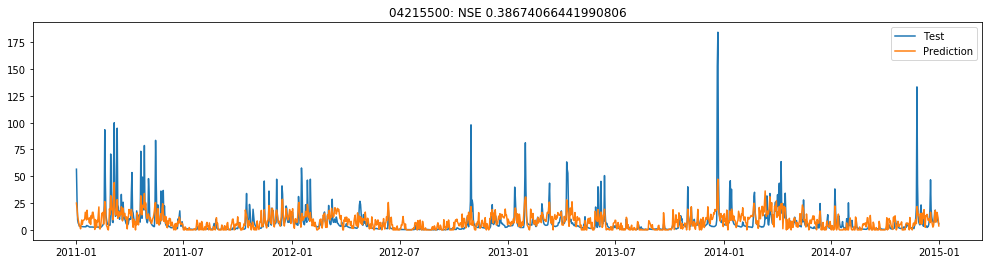

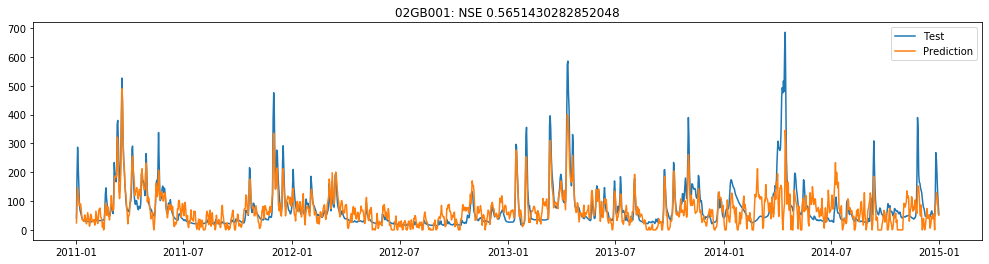

In [9]:
# Evaluate each station
nse_list = []
#plot_list = ['04159492', '02GG013']
for station, predict in predictions.items():
    nse = evaluate.evaluate_daily(station, predict['runoff'], actuals[station], plot=True)
    nse_list.append(nse)
    
    print(station, '\tNSE: (clipped to 0)', nse_list[-1])

print('Median NSE (clipped to 0)', np.median(nse_list), '/ Min', np.min(nse_list), '/ Max', np.max(nse_list))

In [10]:
load_data.pickle_results('LinReg_VIC_aggregateForcings_2011-2014', (predictions, actuals), models=models)

'LinReg_VIC_aggregateForcings_2011-2014_20190630-153231.pkl'